# Пргнозирование с помощью регрессии

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.pipeline import Pipeline
import datetime

Загружаем датасет:

In [5]:
data = pd.read_excel('all_good_cells.xlsx')

In [6]:
data.set_index('start_datetime', inplace = True)

In [7]:
june = pd.read_excel('taxi-2016-06.xlsx')
june = june.set_index('start_datetime')
data = pd.concat([data, june[data.columns]])

In [9]:
data.tail()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
start_datetime,,,,,,,,,,,,,,,,,,,,,
2016-06-30 19:00:00,116,190,135,132,395,308,401,336,496,260,...,2,44,4,297,311,104,9,142,96,1
2016-06-30 20:00:00,104,142,149,141,333,368,390,385,560,247,...,1,27,7,288,344,103,24,209,145,0
2016-06-30 21:00:00,151,162,145,135,359,422,460,541,672,259,...,2,21,9,287,307,185,9,213,142,1
2016-06-30 22:00:00,106,168,103,125,317,476,405,508,578,259,...,3,19,5,358,387,169,12,206,146,0
2016-06-30 23:00:00,85,130,86,113,256,428,483,531,631,210,...,9,0,7,323,110,147,38,173,119,0


Создаем функцию для генерации матрицы признаков. На вход она будет принимать номер ячейки и прогнозируемое число шагов. На выходе будет матрица со столбцами-признаками и столбцом-ответом.

In [121]:
def get_feature_matrix(cell_number, step_forward):
    length = len(data)
    num = cell_number
    #Считаем гармоники
    K = 5
    sins = [np.sin(np.arange(1, length + 1)*2*np.pi*i/168) for i in range(1, K+1)]
    coss = [np.cos(np.arange(1, length + 1)*2*np.pi*i/168) for i in range(1, K+1)]
    #Добавляем тренд
    trends = [range(1, length + 1)]
    #Добавляем 7 бинарных признаков, соответствующих дню недели.
    dayofweek = [[1 if i ==j else 0 for i in data.index.dayofweek] for j in range(7)]
    #Признак - номер ячейки
    num_cells = [num]*length
    #Час, год, месяц, день
    hour = data.index.hour
    year = data.index.year
    month = data.index.month
    dayofmonth = data.index.day
    #Количество поездок, сдвинутое назад на шаг от 1 до 11
    yt_back = [data[num].shift(i) for i in range(1,12)]
    #Попарные разности
    yt_diff = [data[num].shift(i) - data[num].shift(i+1) for i in range(12)]
    #Количество поездок на момент t
    y_now = data[num]
    #Количество поездок, сдвинутое назад на шаг от 1 до 4 суток
    yt_seasonback = [data[num].shift(i) for i in 24*np.array(range(1, 5))]
    #Скользящее среднее окно назад шириной в 6 часов, 12, сутки, неделю, месяц
    rolling_back = [data[num].rolling(i).sum().shift(1) for i in [6, 12, 24, 24*7, 24*7*4]]
    #Вектор-ответ (количество поездок сдвинутое на 1-6 шагов вперед)
    y_forward = data[num].shift(-step_forward)
    
    #Собираем признаки в матрицу
    regressors = np.vstack((num_cells, sins, coss, year, month, dayofmonth, dayofweek, hour, yt_back, yt_diff,\
                        yt_seasonback, rolling_back, y_now, y_forward))
    #Делаем вектор названий
    columns = ['num'] + ['sin_'+str(i) for i in range(1, len(sins)+1)] + ['cos_'+str(i) for i in range(1, len(coss)+1)] + \
    ['year'] + ['month'] + ['dayofmonth'] + ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] + \
    ['hour'] + ['yt_back_'+str(i) for i in range(1, 12)] + ['yt_diff_'+str(i) for i in range(12)] + \
    ['yt_back_'+str(i) for i in 24*np.array(range(1, 5))] + \
    ['rolling_back_'+str(i) for i in [6, 12, 24, 24*7, 24*7*4]] + ['y_now'] + ['y_forward']
    #Собираем датафрейм
    X_data = pd.DataFrame(np.transpose(regressors), columns = columns)
    return X_data.set_index(data.index)

Я не стал брать прогнозы Аримы от прошлой недели. Во-первых, там не было ничего хорошего, во-вторых мне лень обрабатывать выходной файл и приводить его к нужному виду.

Пример матрицы признаков:

In [122]:
t = get_feature_matrix(1075, 1)
print(t.columns)
t.sample(10)

Index(['num', 'sin_1', 'sin_2', 'sin_3', 'sin_4', 'sin_5', 'cos_1', 'cos_2',
       'cos_3', 'cos_4', 'cos_5', 'year', 'month', 'dayofmonth', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'hour', 'yt_back_1', 'yt_back_2', 'yt_back_3', 'yt_back_4', 'yt_back_5',
       'yt_back_6', 'yt_back_7', 'yt_back_8', 'yt_back_9', 'yt_back_10',
       'yt_back_11', 'yt_diff_0', 'yt_diff_1', 'yt_diff_2', 'yt_diff_3',
       'yt_diff_4', 'yt_diff_5', 'yt_diff_6', 'yt_diff_7', 'yt_diff_8',
       'yt_diff_9', 'yt_diff_10', 'yt_diff_11', 'yt_back_24', 'yt_back_48',
       'yt_back_72', 'yt_back_96', 'rolling_back_6', 'rolling_back_12',
       'rolling_back_24', 'rolling_back_168', 'rolling_back_672', 'y_now',
       'y_forward'],
      dtype='object')


,num,sin_1,sin_2,sin_3,sin_4,sin_5,cos_1,cos_2,cos_3,cos_4,...,yt_back_48,yt_back_72,yt_back_96,rolling_back_6,rolling_back_12,rolling_back_24,rolling_back_168,rolling_back_672,y_now,y_forward
start_datetime,,,,,,,,,,,,,,,,,,,,,
2015-11-19 07:00:00,1075.0,0.149042,-0.294755,0.433884,-5.633201e-01,0.680173,-0.988831,9.555728e-01,-0.900969,0.826239,...,44.0,39.0,21.0,73.0,601.0,1549.0,10302.0,41504.0,50.0,108.0
2016-05-17 07:00:00,1075.0,0.930874,0.680173,-0.433884,-9.972038e-01,-0.294755,0.365341,-7.330519e-01,-0.900969,0.074730,...,19.0,25.0,43.0,75.0,476.0,1514.0,11074.0,44403.0,56.0,90.0
2015-08-03 10:00:00,1075.0,0.399892,0.733052,0.943883,9.972038e-01,0.884115,0.916562,6.801727e-01,0.330279,-0.074730,...,50.0,77.0,54.0,216.0,324.0,1553.0,12238.0,50103.0,60.0,67.0
2016-05-30 22:00:00,1075.0,0.757972,0.988831,0.532032,-2.947552e-01,-0.916562,0.652287,-1.490423e-01,-0.846724,-0.955573,...,86.0,78.0,132.0,498.0,998.0,1292.0,11867.0,45663.0,34.0,24.0
2015-07-26 08:00:00,1075.0,-0.532032,-0.900969,-0.993712,-7.818315e-01,-0.330279,0.846724,4.338837e-01,-0.111964,-0.623490,...,76.0,70.0,93.0,81.0,619.0,2137.0,13221.0,48329.0,21.0,31.0
2015-06-27 14:00:00,1075.0,-0.943883,-0.623490,0.532032,9.749279e-01,0.111964,0.330279,-7.818315e-01,-0.846724,0.222521,...,94.0,111.0,121.0,449.0,564.0,1753.0,12707.0,NaN,111.0,130.0
2016-01-16 00:00:00,1075.0,-0.982566,0.365341,0.846724,-6.801727e-01,-0.593820,-0.185912,-9.308737e-01,0.532032,0.733052,...,39.0,30.0,35.0,452.0,961.0,1377.0,9077.0,34916.0,46.0,30.0
2015-08-05 05:00:00,1075.0,0.900969,-0.781831,-0.222521,9.749279e-01,-0.623490,-0.433884,-6.234898e-01,0.974928,-0.222521,...,10.0,6.0,9.0,130.0,716.0,1609.0,12033.0,50115.0,4.0,22.0
2016-03-23 14:00:00,1075.0,0.707107,-1.000000,0.707107,1.303334e-13,-0.707107,-0.707107,-6.516668e-14,0.707107,-1.000000,...,120.0,108.0,111.0,518.0,600.0,1627.0,11227.0,41566.0,108.0,120.0


Создаем функцию для передачи в модель. На входе: номер ячейки, число шагов вперед, дата начала, дата конца. На выходе - кортеж из матрицы признаков X и вектора y. Как видно, функция не делает ничего, кроме заполнения пустот и стандартизации значений. Здесь я выкинул номер ячейки, год и месяц, так как данных у меня всего год, они не несут смысловой нагрузки для модели.

In [123]:
def get_X_y(num, step_forward, start, end):
    t = get_feature_matrix(num, step_forward)
    t = t[start:end]
    t = t.drop(['num', 'year', 'month'], axis = 1).fillna(0)
    y = t['y_forward'].values
    t = (t - t.mean())/t.std()
    X = t.drop(['y_forward'], axis = 1).values
    return (X, y)

Модель будет состоять из пайплайна из генератора полиномиальных признаков (как советовали в задании) и ридж-регрессии (опять же, как в описании). В цикле сразу обучаем пайплайн на периоде до конца апреля, затем прогнозируем май.

In [124]:
%%time

trues = []
preds = []
cnt = 0
j = 0
for num in data.columns:
    for step in range(1, 7):
        d_train = get_X_y(num, step, '2015-06-01', '2016-04-30')
        lr = Pipeline([('poly', PolynomialFeatures(degree=2)), ('linear', linear_model.Ridge())])
        lr.fit(d_train[0], d_train[1])
        d_test = get_X_y(num, step, '2016-04-30 23:00:00', '2016-05-31 17:00:00')
        preds.append(lr.predict(d_test[0]))
        trues.append(d_test[1])

Wall time: 15min 51s


Сделаем датафрейм прогнозов и датафрейм ответов, для наглядности и удобства:

In [125]:
columns = [str(num) + '-' + str(step) for num in data.columns for step in range(1, 7)]
index = data['2016-04-30 23:00:00': '2016-05-31 17:00:00'].index
preds_df = pd.DataFrame(np.transpose(preds), index = index, columns = columns)
trues_df = pd.DataFrame(np.transpose(trues), index = index, columns = columns)

In [28]:
#Датафрейм ответов аналогичный
preds_df.head()

,1075-1,1075-2,1075-3,1075-4,1075-5,1075-6,1076-1,1076-2,1076-3,1076-4,...,2119-3,2119-4,2119-5,2119-6,2168-1,2168-2,2168-3,2168-4,2168-5,2168-6
start_datetime,,,,,,,,,,,,,,,,,,,,,
2016-04-30 23:00:00,75.384382,52.044453,26.036955,17.883514,4.284944,7.816799,92.323888,80.983779,60.342739,22.593608,...,-5.043780,2.394533,-7.468045,-12.017657,81.418560,51.769324,22.625524,-9.392507,-19.504139,46.845044
2016-05-01 00:00:00,43.490114,23.565996,13.191067,2.961632,1.446710,10.190923,29.519757,14.942047,22.972671,0.701302,...,8.879213,-2.117263,6.460647,-11.464252,19.192276,-6.205041,-8.995122,10.900698,47.777276,63.472450
2016-05-01 01:00:00,23.022390,9.823683,8.038945,3.673332,9.522533,15.094275,27.326430,13.080064,7.784548,-7.203400,...,7.241033,11.174444,-8.725275,4.075849,4.985238,0.390983,16.574400,41.353052,54.197636,51.518085
2016-05-01 02:00:00,11.628154,4.749057,7.038926,6.806311,9.039490,22.096908,37.917550,32.635917,11.751442,16.606578,...,14.507332,1.855376,-9.866461,-11.182994,12.505812,22.754981,48.976691,57.989629,56.111461,54.659722
2016-05-01 03:00:00,6.578712,5.927150,10.512018,8.831442,16.818211,47.396273,32.388391,20.344504,32.518554,49.100612,...,11.517567,8.332880,-0.318120,-4.278039,28.288207,50.516915,62.687100,54.218563,49.122036,47.384195


Функция для расчета функционала ошибки Q:

In [126]:
def compute_Q(trues, preds):
    return np.sum(np.abs(preds - trues).values)/trues.size

#Считаем ошибку на мае.
compute_Q(trues_df, preds_df)

23.680838925034621

В следующей ячейке пример прогноза:

Q = 11.6236534239


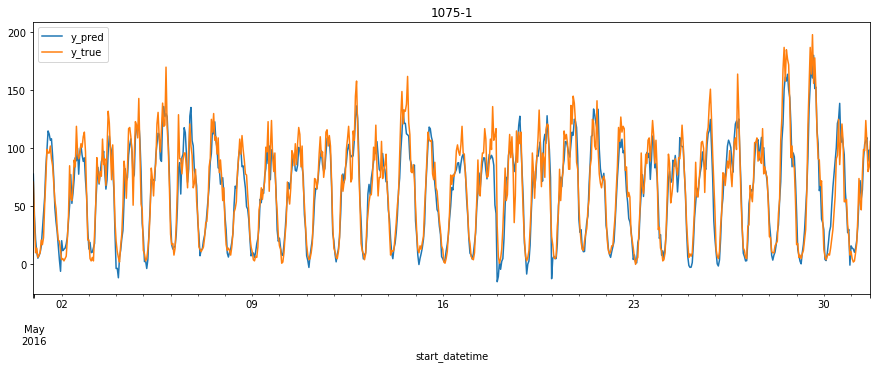

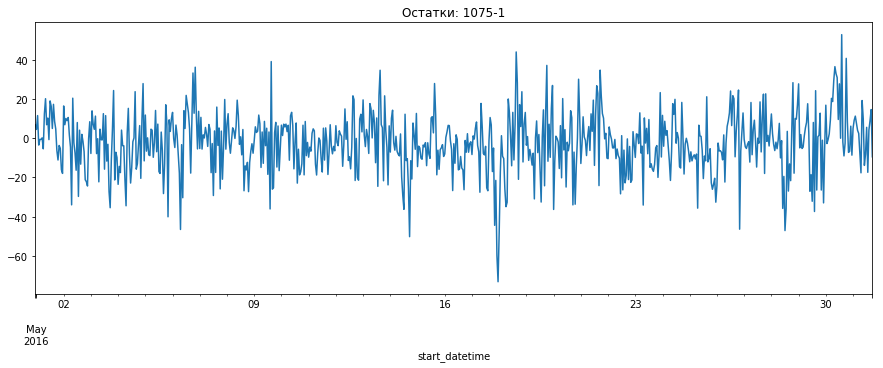

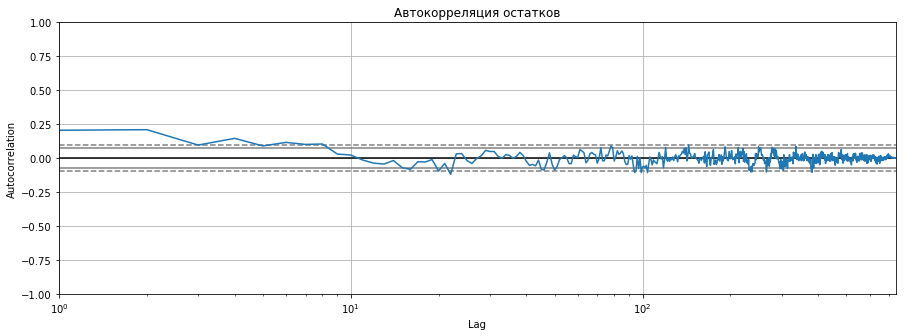

In [127]:
i = 0
print('Q = ' + str(compute_Q(trues_df[columns[i]], preds_df[columns[i]])))
preds_df[columns[i]].plot(figsize = (15, 5))
trues_df[columns[i]].plot(figsize = (15, 5))
plt.title(columns[i])
plt.legend(['y_pred', 'y_true'])
plt.show()

(preds_df[columns[i]] - trues_df[columns[i]]).plot(figsize = (15, 5))
plt.title('Остатки: ' + columns[i])
plt.show()

from pandas.plotting import autocorrelation_plot
plt.figure(figsize = (15,5))
ax = autocorrelation_plot((preds_df[columns[i]] - trues_df[columns[i]]))
ax.set_xscale("log", nonposx='clip')
plt.title('Автокорреляция остатков')
plt.show()

Выглядит как будто мы не учли соседние лаги в регрессии, но мы их учитывали.

Посмотрим как ошибка зависит от количества часов вперед:

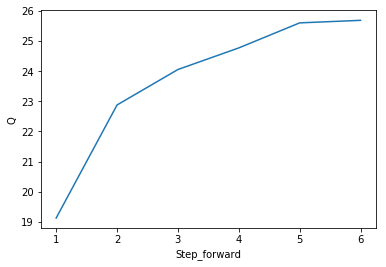

In [128]:
y = [compute_Q(trues_df[columns[i::6]], preds_df[columns[i::6]]) for i in range(6)]
plt.plot(range(1, 7), y)
plt.ylabel('Q')
plt.xlabel('Step_forward')
plt.show()

Считаем прогноз на июнь:

In [129]:
%%time

trues_j = []
preds_j = []
cnt = 0
j = 0
for num in data.columns:
    for step in range(1, 7):
        d_train = get_X_y(num, step, '2015-06-01', '2016-05-31')
        lr = Pipeline([('poly', PolynomialFeatures(degree=2)), ('linear', linear_model.Ridge())])
        lr.fit(d_train[0], d_train[1])
        d_test = get_X_y(num, step, '2016-05-31 23:00:00', '2016-06-30 17:00:00')
        preds_j.append(lr.predict(d_test[0]))
        trues_j.append(d_test[1])

Wall time: 18min 58s


In [130]:
columns = [str(num) + '-' + str(step) for num in data.columns for step in range(1, 7)]
index = data['2016-05-31 23:00:00': '2016-06-30 17:00:00'].index
preds_df = pd.DataFrame(np.transpose(preds_j), index = index, columns = columns)
trues_df = pd.DataFrame(np.transpose(trues_j), index = index, columns = columns)

In [131]:
compute_Q(trues_df, preds_df)

23.821134356298497

Запишем ответы в файл и отправим на каггл:

In [132]:
ans = []
for zs in preds_df.columns:
    for date in preds_df.index.values:
        zone_step = zs.split('-')
        zone = zone_step[0]
        step = zone_step[1]
        dates = (lambda x: x[0] + '_' + str(int(x[1][:2])))(str(date).split('T'))
        ans.append([zone, dates, step, preds_df[zs][date]])

In [133]:
ans_df = pd.DataFrame(ans, columns = ['cell', 'date', 'step', 'y'])
ans_df = ans_df.sort_values(by=['cell', 'date', 'step'])

In [134]:
ans_df['id'] = ans_df['cell'].astype(str) + '_' + ans_df['date'] + '_' + ans_df['step']

In [135]:
ans_df[['id','y']].to_csv('taxi_week5_output1.csv', index = False)

Ссылка на сабмишн:
https://inclass.kaggle.com/c/yellowtaxi/leaderboard?submissionId=4995854

![title](im1.png)

Норм, не то что раньше (на прошлой неделе было 69.9). А главное, все быстро и без тормозов.

Давайте теперь посмотрим на коэффициенты перед признаками. Какие признаки наиболее важны для прогноза?

In [192]:
ridge = lr.named_steps['linear']
poly = lr.named_steps['poly']
feature_names = get_feature_matrix(1075, 1).drop(['num', 'year', 'month', 'y_forward'], axis = 1).columns
coefs = pd.DataFrame([ridge.coef_], columns = poly.get_feature_names(feature_names), index=['coef']).transpose()

In [203]:
coefs[np.abs(coefs['coef'])>=10].sort_values(by = 'coef', ascending=False)

,coef
hour,104.038837
hour^2,59.910257
sin_5 Monday,52.980252
cos_5 Friday,43.029961
cos_5 Tuesday,41.175196
cos_5 Monday,40.896491
sin_5 Thursday,36.861122
cos_4 Monday,34.998003
cos_4 Saturday,24.533406
sin_4 Wednesday,24.065650


Интересно, но непонятно. Если час и час в квадрате еще можно объяснить суточной сезонностью, то гармоники в значимых признаках видеть странно. И удивидетельно, что здесь нет значений в предыдущие моменты времени.